# **Module 6/7: Project 2: Music Genre Classification Analysis Cont.**
#### Saanvi Agrawal, Nithin Jakrebet, Kaytlyn Daffern
#### 12/5/2024



## **Introduction**

### Project Background:
- **Dataset Source:** Kaggle - Music Genre Classification
- **Data Files:** Includes train.csv for model training, test.csv for evaluation, and submission.csv for genre labels
- **Objective:** Use acoustic features to explore music genres.

### Problem Definition (Key Questions):
1. Can we identify clusters of genres based on energy and tempo?
2. How does the distribution of features like danceability or loudness vary across genres?
3. What is the tempo distribution across different genres?
4. What is the correlation between key acoustic features?

## **Dataset Overview and Setup**

### Overview of Features
- **Key Features:** Energy, Tempo, Danceability, Acousticness, Loudness
- **Target Variable:** Genre

### Training and Testing Sets
- **Train.csv:** Used to build and train the model.
- **Test.csv:** Used for evaluation to assess model generalization.
- **Submission.csv:** Provides the genre labels for the test set.

### Data Import and Setup
- Loading the training and testing datasets.
- Extracting genre labels from the submission data.

### Data Wrangling and Cleaning
- Identifying numeric columns to ensure compatibility for modeling.
- Normalizing the data to put both datasets on the same scale for better performance when modeling. Then it is converted back into a dataframe.
- The target column 'Class' is reintroduced for clustering later using k-means.

### Model Training and Clustering
- **Genre Mapping:** Using a dictionary to map class labels to their corresponding genre names.
- **Clustering with k-Means:** Grouping the data based on 'energy' and 'tempo' using the k-Means algorithm.

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train_data = pd.read_csv("/train.csv")
test_data = pd.read_csv("/test.csv")
submissions_data = pd.read_csv("/submission.csv")

# Combine genre binary indicators into a single 'Actual_Genre' column
def get_genre_label(row):
    genres = row.index[row == 1].tolist()
    return genres[0] if len(genres) == 1 else np.nan

submissions_data['Actual_Genre'] = submissions_data.apply(get_genre_label, axis=1)

In [5]:
# Identify numeric columns in train and test data, excluding the target column 'Class' from train
train_numeric_features = train_data.select_dtypes(include=[np.number]).columns.drop('Class', errors='ignore')
test_numeric_features = test_data.select_dtypes(include=[np.number]).columns

# Keep only the common numeric features between train and test
common_features = train_numeric_features.intersection(test_numeric_features)

# Normalize the data
scaler = StandardScaler()
train_normalized = scaler.fit_transform(train_data[common_features])  # Fit and transform on train data
test_normalized = scaler.transform(test_data[common_features])  # Only transform on test data

# Convert normalized data back to DataFrame
train_normalized = pd.DataFrame(train_normalized, columns=common_features)
test_normalized = pd.DataFrame(test_normalized, columns=common_features)

# Add the 'Class' column back to the training normalized DataFrame for clustering
train_normalized['Class'] = train_data['Class'].reset_index(drop=True)

In [6]:
# Map the class to genres
genre_mapping = {
    0: "Acoustic/Folk", 1: "Alt", 2: "Blues",
    3: "Bollywood", 4: "Country", 5: "HipHop",
    6: "Indie Alt", 7: "Instrumental", 8: "Metal",
    9: "Pop", 10: "Rock"
}

n_genres = len(genre_mapping)  # Number of genres in genre_mapping
data_features = train_normalized[['energy', 'tempo']]

# Fit k-Means with the updated number of clusters
kmeans = KMeans(n_clusters=n_genres, random_state=123)
train_normalized['Class'] = kmeans.fit_predict(data_features)

# Predict clusters for the test data
test_normalized['Class'] = kmeans.predict(test_normalized[['energy', 'tempo']])

# Add the genre mapping to the test data
test_normalized['Genre'] = test_normalized['Class'].map(genre_mapping)

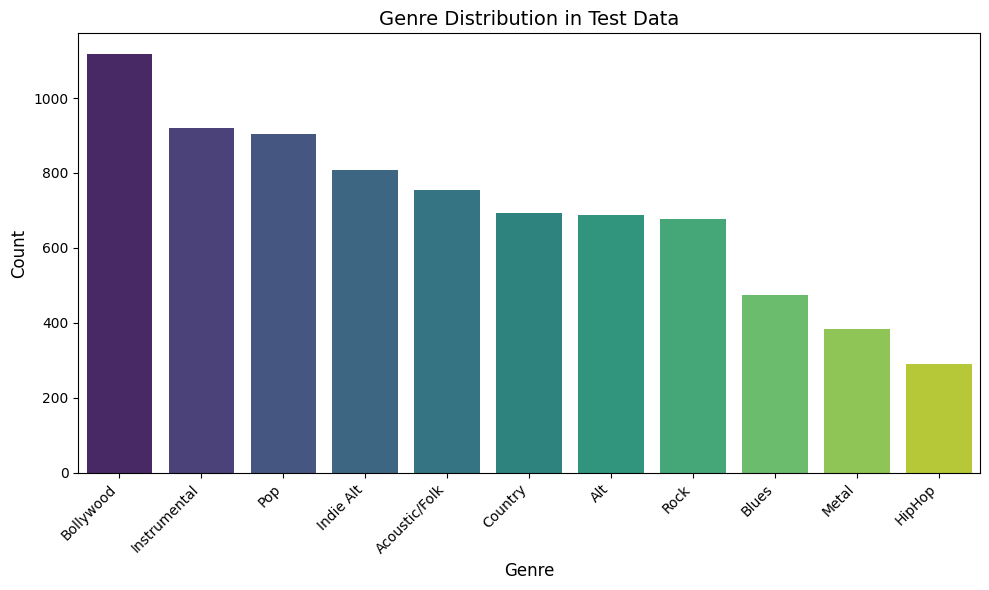

In [7]:
# Count the number of songs for each genre in the test dataset
genre_counts = test_normalized['Genre'].value_counts()

# Create a bar plot to visualize the distribution of genres
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis', hue=genre_counts.index)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.title('Genre Distribution in Test Data', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

## **1. Can we identify clusters of genres based on energy and tempo?**

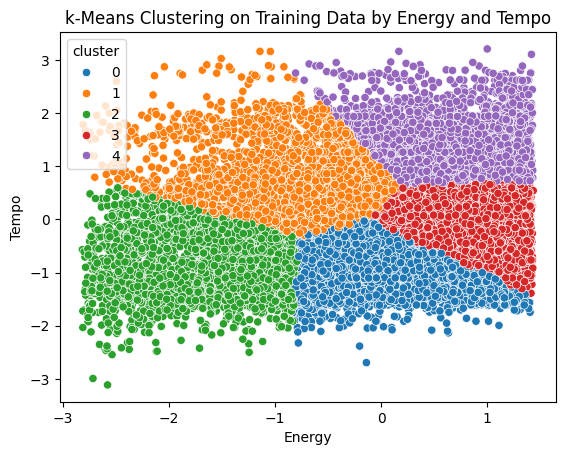

In [8]:
# k-Means clustering on 'energy' and 'tempo'
data_features = train_normalized[['energy', 'tempo']]
kmeans = KMeans(n_clusters=5, random_state=123)
train_normalized['cluster'] = kmeans.fit_predict(data_features)

# Plot clustering results
sns.scatterplot(data=train_normalized, x='energy', y='tempo', hue='cluster', palette='tab10')
plt.title("k-Means Clustering on Training Data by Energy and Tempo")
plt.xlabel("Energy")
plt.ylabel("Tempo")
plt.show()

### **Summary of Findings for Q.1**
- Genres were grouped by energy and tempo, showing natural clusters for some genres. This clustering validated the separability of genres in feature space.



## **2. How does the distribution of features like danceability or loudness vary across genres?**

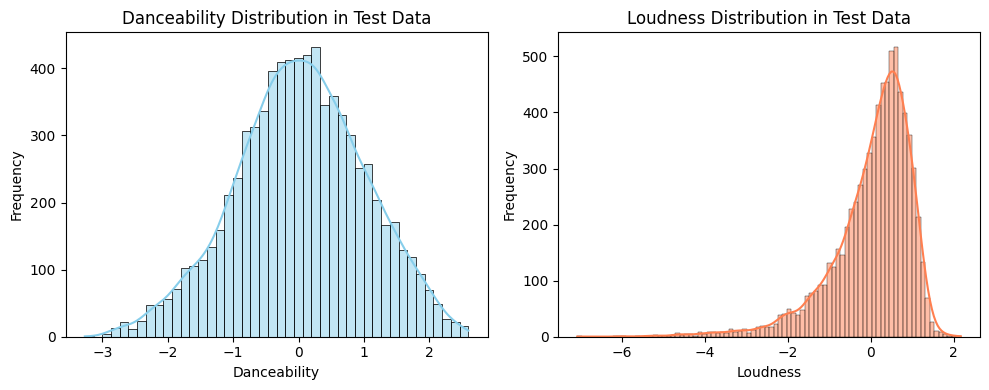

In [9]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogram for 'danceability'
sns.histplot(data=test_normalized, x='danceability', kde=True, color='skyblue', ax=axes[0])
axes[0].set_title("Danceability Distribution in Test Data")
axes[0].set_xlabel("Danceability")
axes[0].set_ylabel("Frequency")

# Histogram for 'loudness'
sns.histplot(data=test_normalized, x='loudness', kde=True, color='coral', ax=axes[1])
axes[1].set_title("Loudness Distribution in Test Data")
axes[1].set_xlabel("Loudness")
axes[1].set_ylabel("Frequency")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

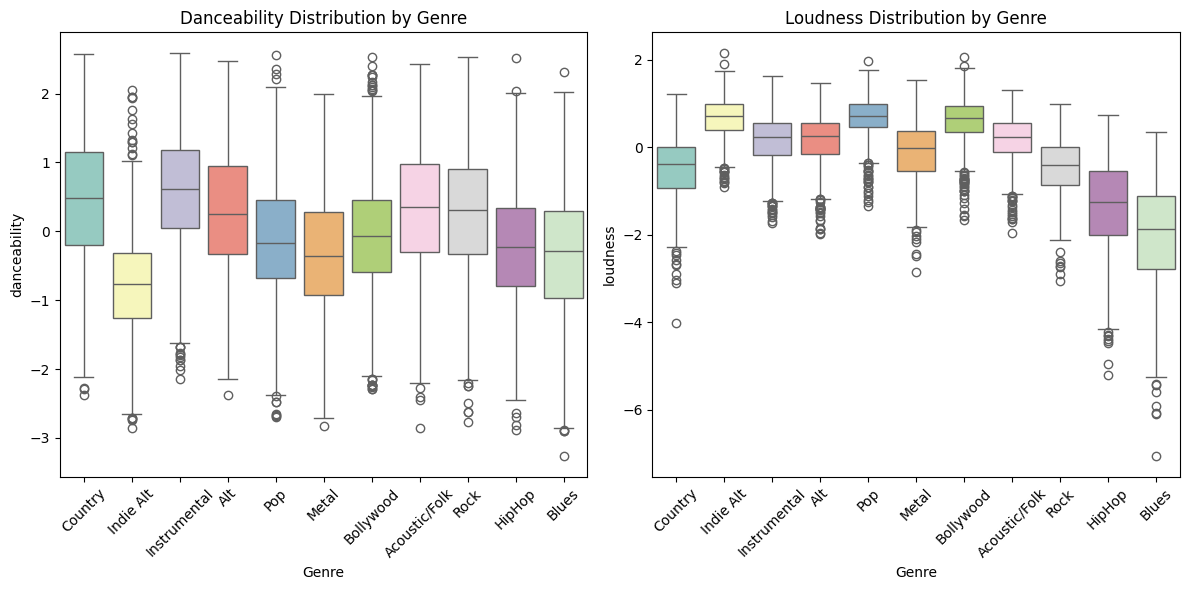

In [10]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot for 'danceability' by Genre
sns.boxplot(data=test_normalized, x='Genre', y='danceability', hue='Genre', palette='Set3', ax=axes[0])
axes[0].set_title("Danceability Distribution by Genre")
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Boxplot for 'loudness' by Genre
sns.boxplot(data=test_normalized, x='Genre', y='loudness', hue='Genre', palette='Set3', ax=axes[1])
axes[1].set_title("Loudness Distribution by Genre")
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

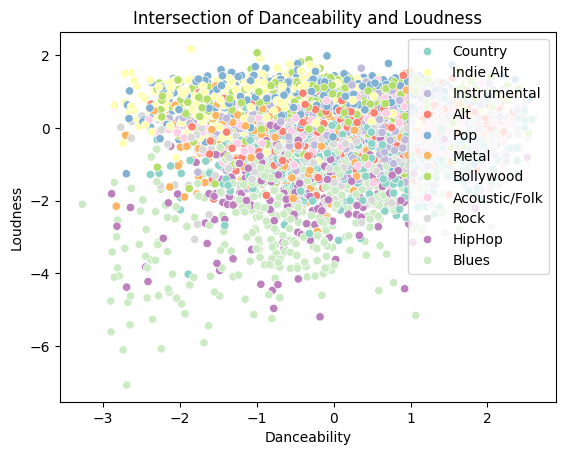

In [11]:
# Scatter plot for 'danceability' vs 'loudness'
sns.scatterplot(data=test_normalized, x='danceability', y='loudness', hue='Genre', palette='Set3')
plt.title("Intersection of Danceability and Loudness")
plt.xlabel("Danceability")
plt.ylabel("Loudness")
plt.legend(loc='upper right')
plt.show()

### **Summary of Findings for Q.2**
- Analysis revealed distinct distributions for danceability and loudness across genres.
- The intersection plot indicates a notable relationship, suggesting that certain genres may exhibit higher danceability with increased loudness.
- Future exploration could involve further investigation into how these features influence genre classification and performance metrics.


## **3. What is the tempo distribution across different genres?**




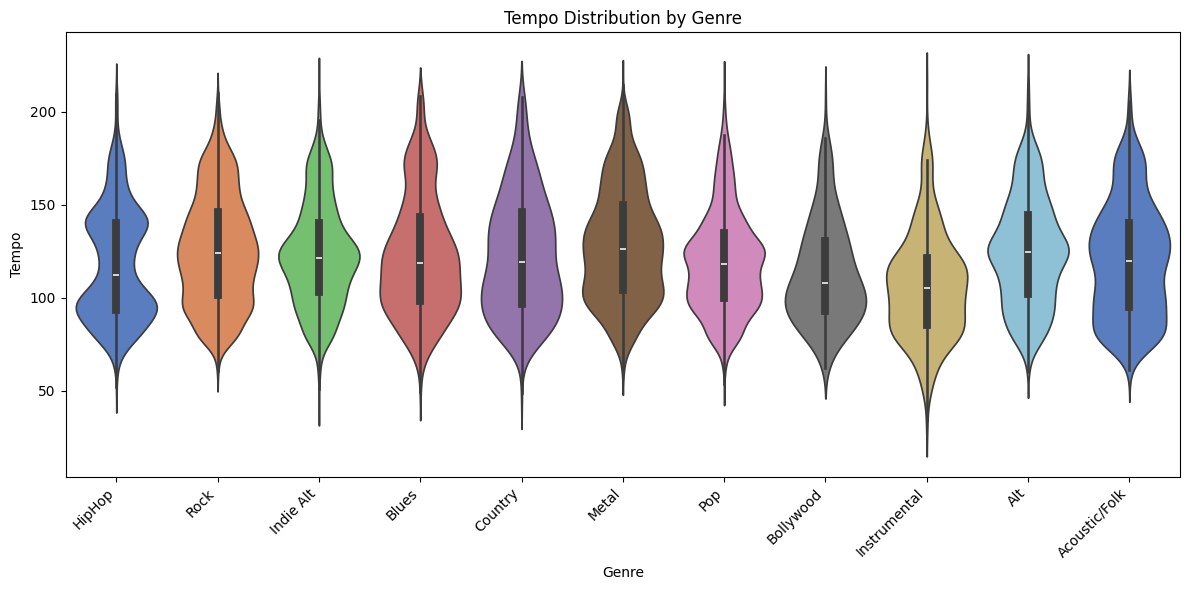

In [14]:
# Violin plot for tempo by genre
plt.figure(figsize=(12, 6))
train_data['Genre'] = train_data['Class'].map(genre_mapping)
sns.violinplot(data=train_data, x='Genre', y='tempo', hue='Genre', palette='muted')
plt.title('Tempo Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Tempo')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### **Summary of Findings for Q.3**
- Metal and Rock genres display a wider tempo range, indicating diverse rhythmic structures.
- Pop and HipHop have more tightly clustered tempos, reflecting their often steady beats.
- Instrumental and Blues genres exhibit more variability in tempo, likely due to their improvisational and dynamic nature.




## **4. What is the correlation between key acoustic features?**

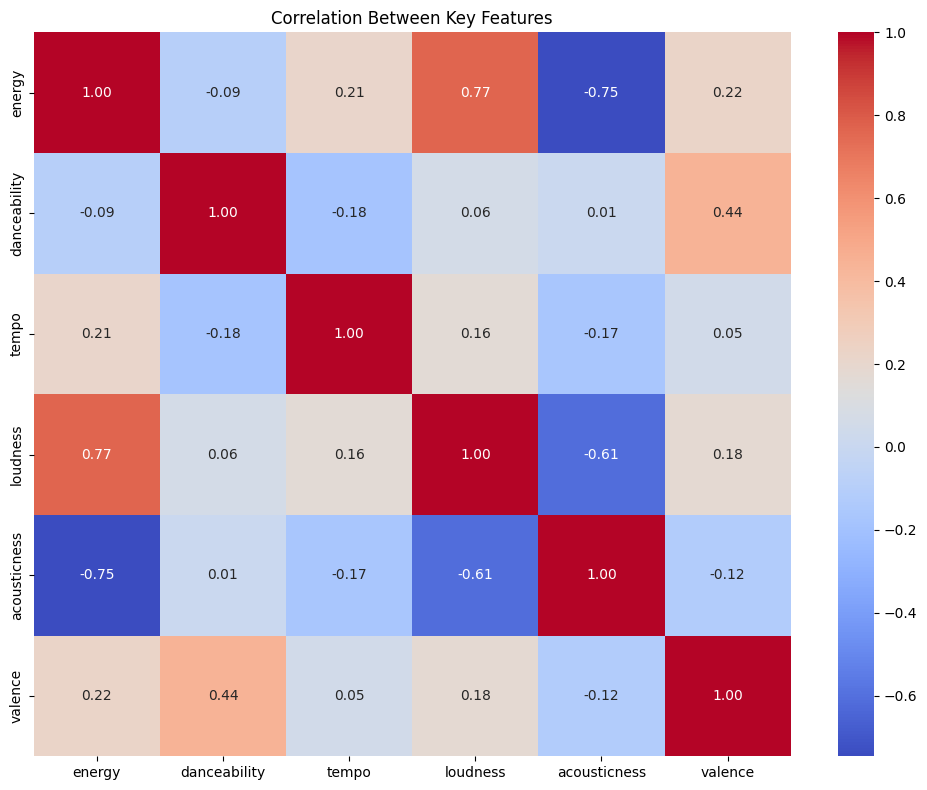

In [15]:
# Calculate correlations between key features
key_features = ['energy', 'danceability', 'tempo', 'loudness', 'acousticness', 'valence']
correlation_matrix = train_data[key_features].corr()

# Heatmap for correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Between Key Features')
plt.tight_layout()
plt.show()

### **Summary of Findings for Q.4**
- Strong positive correlation observed between energy and loudness, as expected in more dynamic songs.
- Danceability shows a moderate positive correlation with tempo and valence, indicating its relationship with upbeat tracks.
- Acousticness is negatively correlated with loudness and energy, aligning with its softer and more natural sound profile.

## **Final Conclusion**

This project gave us a closer look at how different music genres stand out based on their acoustic features. We found that genres like Metal and Rock tend to be high-energy and fast-paced, while Acoustic/Folk and Instrumental are softer and slower. Pop and HipHop were consistent with their danceability and popularity, making them easy favorites for mainstream listeners.

The clustering analysis showed how energy and tempo can naturally group songs into genres, and the distribution plots highlighted some unique patterns, like the wide tempo range in Blues and Instrumental tracks. The correlation analysis added more depth, showing strong links between energy and loudness, while also pointing out how features like danceability and valence work together.

Overall, this was a fun way to uncover the hidden traits of music genres. It’s clear that data can add a new layer of understanding to something as creative as music, and there’s plenty of room to dig even deeper in the future!